In [18]:
import pandas as pd
import numpy as np 
import rasterio
import rioxarray
import matplotlib.pyplot as plt 
import xarray as xr
import math
import seaborn as sns
from sklearn.metrics import r2_score

class Analysis:
    def __init__(self, input, gnd_truth, icesat_path=None) -> None:
        self.inp = rioxarray.open_rasterio(input, band_as_variable=True)
        self._tmp = rioxarray.open_rasterio(gnd_truth, band_as_variable=True)
        self._gnd = self._tmp.rio.reproject_match(self.inp)
        self.gnd = self._gnd.sel(
            x=slice(self._tmp['x'].min()+0.01, self._tmp['x'].max()-0.01),
            y=slice(self._tmp['y'].min()+0.01, self._tmp['y'].max()-0.01)
            )
        self.diff = self.inp - self.gnd
        abdiff = abs(self.diff).band_1.to_numpy().flatten()
        diff = self.diff.band_1.to_numpy().flatten()
        self.icesat = pd.read_csv(icesat_path)
        
        print("min diff &", round(np.min(diff),3), "\\")
        print("max diff &", round(np.max(diff),3), "\\")
        print("median diff &", round(np.median(diff),3) , "\\")
        print("mean diff &", round(np.mean(diff),3), "\\")
        print("std &", round(np.std(diff),3), "\\")
        rmse = math.sqrt(np.mean(diff**2))
        print("rmse &", round(rmse,3))
        print("mae &", round(np.mean(abdiff),3))
    
    def tester_diff(self, tester_diff):
        out = tester_diff.sel(
            x=slice(self.gnd['x'].min()+0.03, self.gnd['x'].max()-0.03),
            y=slice(self.gnd['y'].min()+0.03, self.gnd['y'].max()-0.03)
        )
        return out

    def get_pred_h(self, results):
        self.rf_results = rioxarray.open_rasterio(results, band_as_variable=True)
        
    def set_ground_truth(self, gt_tif):
        self.ground_truth = rioxarray.open_rasterio(gt_tif, band_as_variable=True)
        self.ground_truth = self.ground_truth.sel(
        x=slice(self.input_data['x'].min()+0.0, self.input_data['x'].max()-0.0),
        y=slice(self.input_data['y'].min()+0.0, self.input_data['y'].max()-0.0)
        )
        return self.ground_truth

    def set_test_data(self, test_data_tif):
        self.test_data = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data
    
    def get_difference(self):
        self.ground = self.ground_truth.rio.reproject_match(self.test_data)
        self.difference = self.test_data - self.ground
        self.absDifference = abs(self.test_data - self.ground)
    
    def calc_rmse(self):
        diff = self.test_data - self.ground
        diff_sq = diff ** 2
        mean = diff_sq.band_1.mean()
        rmse = math.sqrt(mean)
        return rmse
    
    def plot1(self, chart_title):
        self.inp = self.inp.sel(
            x=slice(self.inp['x'].min()+0.0, self.inp['x'].max()-0.0),
            y=slice(self.inp['y'].min()+0.0, self.inp['y'].max()-0.0)
            )
        self.inp.band_1.plot(cmap='gist_earth',
                            vmin=self.inp.band_1.min(), 
                            vmax=self.inp.band_1.max())
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(chart_title)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.tick_params(axis='x', rotation=90)
        
    def plot2(self, chart_title, icesat='off'):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        self.inp = self.inp.sel(
            x=slice(self.gnd['x'].min()+0.0, self.gnd['x'].max()-0.0),
            y=slice(self.gnd['y'].min()+0.0, self.gnd['y'].max()-0.0)
            )

        self.inp.band_1.plot(cmap='gist_earth', ax=axes[0], 
                                     vmin=self.inp.band_1.min(), 
                                     vmax=self.inp.band_1.max())
        self.diff.band_1.plot(cmap='RdBu', ax=axes[1])
        
        for ax in axes:
            ax.tick_params(axis='x', rotation=45)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
        if icesat=='on':
            axes[0].scatter(self.icesat['lon'], self.icesat['lat'], marker='.', c='red', s=1, label='ICESat Points', alpha=0.3)
            axes[1].scatter(self.icesat['lon'], self.icesat['lat'], marker='.', c='red', s=1, label='ICESat Points', alpha=0.3)
        else:
            pass
        axes[0].set_title(chart_title)
        axes[1].set_title('Difference against Ground Truth')
    
    def cross_section(self):
        pass
    
    def plot3(self):
        sns.set_context("paper")
    
        diff = self.diff.band_1.to_numpy().flatten()
        mean = np.mean(diff)
        std_dev = np.std(diff)

        # Define a threshold to filter out values larger than 3SD from the mean
        threshold = mean + 3 * std_dev
        testerdiff1 = self.tester_diff(self.diff)
        testerdiff2 = self.tester_diff(self.inp)

        # Filter the data to exclude values larger than 3SD
        f_tester_diff = [x for x in self.test_data if x <= threshold]

        plt.hist(testerdiff1.band_1.to_numpy().flatten(), bins=110, edgecolor=None, alpha=0.4, label='Laplace Interpolation')
        plt.hist(testerdiff2.band_1.to_numpy().flatten(), bins=110, edgecolor=None, alpha=0.6, label='Random Forest')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.show()

    def plot4(self):
        plt.scatter(self.icesat['lon'], self.icesat['lat'], marker='.', c='green', s=0.1, label='ICESat Points', alpha=0.2)
        plt.show(chart_title='asdf')


## Tasmania Tests

min diff & -594.567 \
max diff & 627.791 \
median diff & 0.0 \
mean diff & -0.53 \
std & 55.563 \
rmse & 55.565
mae & 31.742


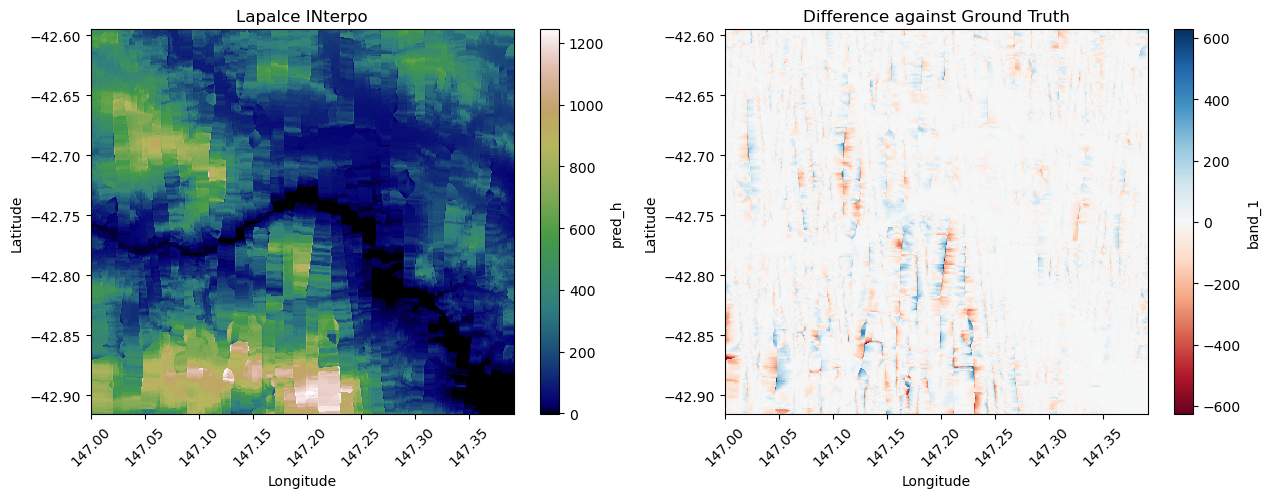

In [22]:
AU_truth = '../ICESAT/tasmania/gnd_dem_01.tif'
pred = r"../ICESAT/tasmania/results/tasmania__geometricOnly.tif"
# res = '../ICESAT/tasmania/results/tasmania_1-slope.tif'
laplace = '../ICESAT/tasmania/interpolation/interpSamples_laplace.tif'
tester = Analysis(pred, AU_truth, icesat_path=r"../ICESAT/tasmania/tasmania_g.csv")
tester.plot2(chart_title="Lapalce INterpo", icesat='off')


### NL Tests

min diff & -206.447 \
max diff & 65.0 \
median diff & 0.0 \
mean diff & -0.561 \
std & 9.527 \
rmse & 9.544
mae & 4.235


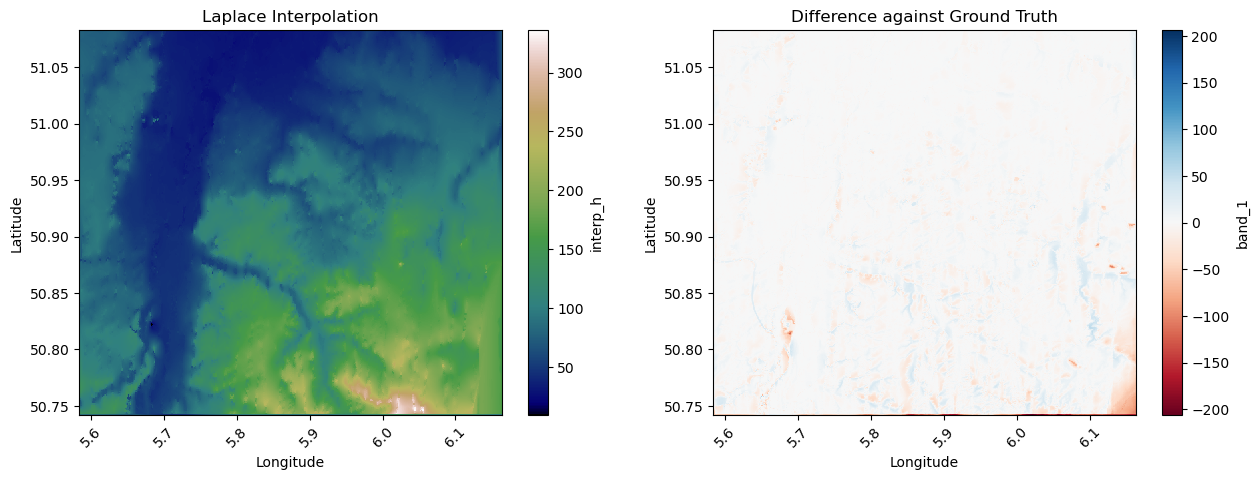

In [31]:
NL_truth = '../ICESAT/zlimburg/gnd_eu_dem.tif'
pred = r"../ICESAT/zlimburg/interpLaplace.tif"
# res = '../ICESAT/tasmania/results/tasmania_1-slope.tif'
# laplace = '../ICESAT/tasmania/interpolation/interpSamples_laplace.tif'
tester = Analysis(pred, NL_truth, icesat_path=r"../ICESAT/zlimburg/zlimburg_g.csv")
tester.plot2(chart_title="Laplace Interpolation", icesat='off')


min diff & -792.423 \
max diff & 931.947 \
median diff & -24.821 \
mean diff & -32.9 \
std & 103.934 \
rmse & 109.017
mae & 69.526


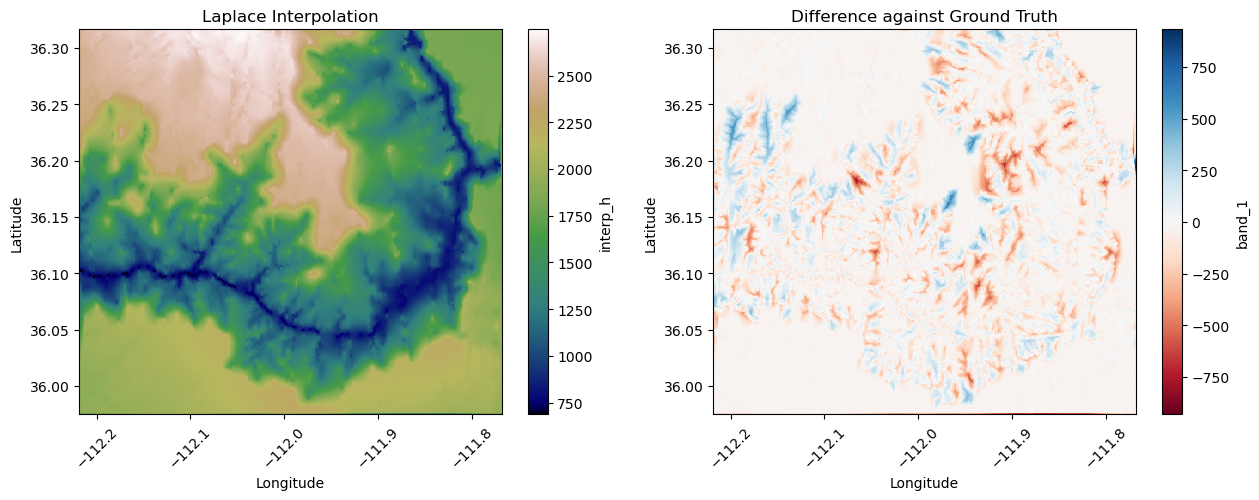

In [25]:
GC_truth = '../ICESAT/gcanyon/gnd_gcaynon.tif'
pred = r"../ICESAT/gcanyon/rf_features_tmp/interp_other/interpLaplace.tif"

# res = '../ICESAT/tasmania/results/tasmania_1-slope.tif'
# laplace = '../ICESAT/tasmania/interpolation/interpSamples_laplace.tif'
tester = Analysis(pred, GC_truth, icesat_path=r"../ICESAT/gcanyon/grand_canyon_g.csv")
tester.plot2(chart_title="Laplace Interpolation", icesat='off')

min diff & -770.826 \
max diff & 526.337 \
median diff & 0.002 \
mean diff & 0.246 \
std & 28.423 \
rmse & 28.424
mae & 11.092


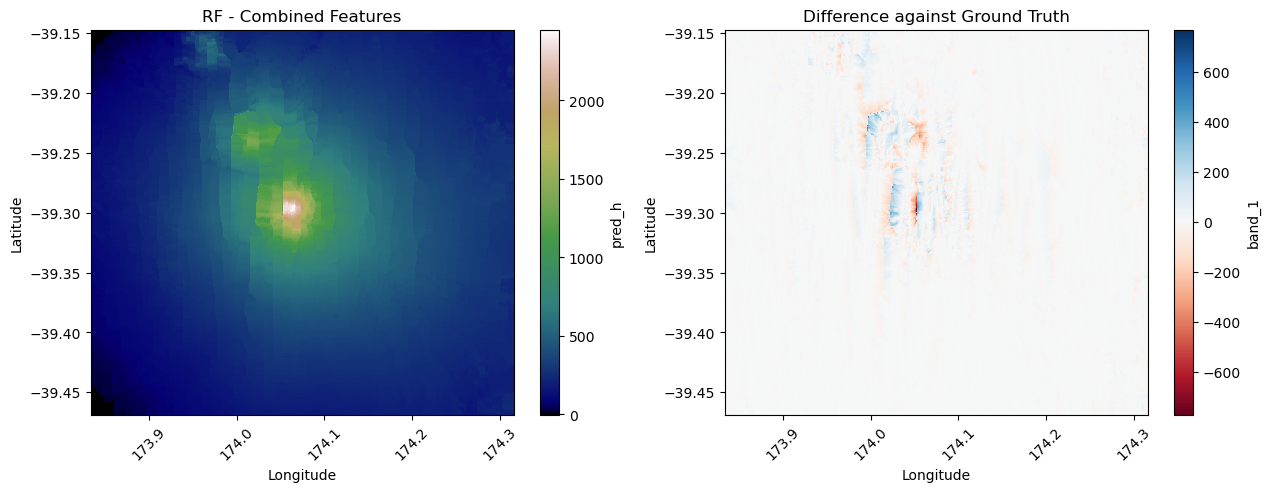

In [16]:
NZ_truth = '../ICESAT/nzealand/gnd_taranaki.tif'
pred = r"../ICESAT/nzealand/results/taranaki_pred_toptimal_geometricOnly.tif"
# res = '../ICESAT/tasmania/results/tasmania_1-slope.tif'
# laplace = '../ICESAT/tasmania/interpolation/interpSamples_laplace.tif'
tester = Analysis(pred, NZ_truth, icesat_path=r"../ICESAT/nzealand/taranaki_g.csv")
tester.plot2(chart_title="RF - Combined Features", icesat='off')
